https://discourse.aicrowd.com/t/end-to-end-solution-that-gives-above-80-accuracy/3778

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset#
from torch import optim
import os
import numpy as np

import cv2
from tqdm.notebook import tqdm, trange
import datetime 
from IPython.display import HTML
import cv2

from _torch.architectures import UNet, MultiResUnet
from _torch.losses import MulticlassDiceLoss, accuracy
from _torch.data import DataGenerator
from utils import normalize_only

In [2]:
rootpath = '/nas/public/dataset/geophysics/2020_aicrowd_facies_segmentation_challenge/'
sei_patch = np.load(os.path.join(rootpath, 'data_train.npz'))['data']
lab_patch = np.load(os.path.join(rootpath, 'labels_train.npz'))['labels']

In [3]:
lab_patch[lab_patch==6] = 0

In [4]:
sei_patch.shape , lab_patch.shape

((1006, 782, 590), (1006, 782, 590))

#### changing label IDs

In [6]:
def shuffle_labels(n=6):
    x = np.random.permutation(n)
    if np.all(x == np.arange(n)):
        x = shuffle_labels(n)
        
    return x

In [7]:
lab_patch_new = lab_patch.copy()

new_class_ids = shuffle_labels(6)
print('New labels:', new_class_ids)

for i in range(6):
    lab_patch[lab_patch_new==i] = new_class_ids[i]

del lab_patch_new

New labels: [2 0 3 4 5 1]


#### Normalize seismic data

In [5]:
_min = sei_patch.min()
_max = sei_patch.max()
sei_patch = normalize_only(sei_patch, in_min=_min, in_max=_max)

## Training

In [5]:
training_img_data = []
training_label_data = []

# Define the X lines slices for training
for i in trange(0, sei_patch.shape[1], desc='ZY sections'):
    img = sei_patch[:, i, :]
    label = lab_patch[:, i, :]

    img = np.expand_dims(img, axis=2).astype('float32')
    label = np.expand_dims(label, axis=2).astype('float32')

    img = cv2.resize(img, (256, 512), interpolation=cv2.INTER_AREA)
    label = cv2.resize(label, (256, 512), interpolation = cv2.INTER_NEAREST)
    label = label.astype(int)

    training_img_data.append(img) 
    training_label_data.append(label)

# Define the Y lines slices for training
for i in trange(0, sei_patch.shape[2], desc='ZX sections'):
    img = sei_patch[:, :, i]
    label = lab_patch[:, :, i]
    
    img = np.expand_dims(img, axis=2).astype('float32')
    label = np.expand_dims(label, axis=2).astype('float32')

    img = cv2.resize(img, (256, 512), interpolation=cv2.INTER_AREA)
    label = cv2.resize(label, (256, 512), interpolation = cv2.INTER_NEAREST)
    label = label.astype(int)

    training_img_data.append(img) 
    training_label_data.append(label)


In [6]:
training_img_data = np.asarray(training_img_data)
training_label_data = np.asarray(training_label_data)
training_label_data = np.array(training_label_data,dtype=int)
training_img_data.shape, training_label_data.shape

((1372, 512, 256), (1372, 512, 256))

In [7]:
from torch.nn import functional as F

def train(model, optimizer, dataload, num_epochs, device, outpath, e=1e-2, l2=0., l1=0.):
    acc_history  = []
    loss_history = []
    miou_history = []
    
    for epoch in range(num_epochs):
        print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        since = time.time()
        
        dataset_size = len(dataload.dataset)
        epoch_loss = 0
        epoch_acc  = 0

        for idx, (x, y) in enumerate(dataload):                 
            
            optimizer.zero_grad()             
            
            inputs = x.to(device)
            labels = y.to(device)
            
            outputs = model(inputs)           
            
            criterion1 = MulticlassDiceLoss() 
            loss1 = criterion1(outputs, labels.long())
            
            criterion2 = torch.nn.CrossEntropyLoss()
            loss2 = criterion2(torch.log(outputs), labels.long())
            
            loss = e*loss1+loss2
            
            # weights reg
            l2_reg = None
            l1_reg = None
            for p in model.parameters():
                
                if l2_reg is None:
                    l2_reg = p.norm(2)
                else:
                    l2_reg = l2_reg + p.norm(2)
                
                if l1_reg is None:
                    l1_reg = p.norm(1)
                else:
                    l1_reg = l1_reg + p.norm(1)
            
            if l2 > 0.:
                loss = loss + l2*l2_reg
            if l1 > 0.:
                loss = loss + l1*l1_reg
                
            acc  = accuracy(outputs,labels)
            
            loss.backward()                  
            optimizer.step()                  
            
            epoch_loss += loss.item()
            epoch_acc+= acc
            loss_history.append(loss.item())
            acc_history.append(acc)
            
            if (idx+1)%10 == 0:
                print("%d/%d,train_loss:%0.3f,accuracy:%0.3f"
                      % (idx+1, dataset_size // dataload.batch_size, loss.item(),acc))

        time_elapsed = time.time() - since     
        
        all_epoch_loss=epoch_loss/len(dataload)
        all_epoch_acc=epoch_acc/len(dataload)
        
        print("epoch %d loss:%0.3f accuracy:%0.3f " % (epoch, all_epoch_loss,all_epoch_acc))
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model, os.path.join(outpath, '_model.pth'))
    
    return model, loss_history, acc_history


def seisfacies_predict(model, section, patch_size=256,overlap=0,onehot=0,device='cpu'): 
    
    model = model.to(device)
    
    m1,m2 = section.shape
    os    = overlap                                 
    
    n1,n2 = 512,patch_size           
    
    c1 = int(np.round((m1+os)/(n1-os)+0.5))
    c2 = int(np.round((m2+os)/(n2-os)+0.5))
    
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os

    gp = np.zeros((p1,p2),dtype=np.single)     
    gy = np.zeros((6,p1,p2),dtype=np.single)    
    gs = np.zeros((n1,n2),dtype=np.single) 
    
    gp[0:m1,0:m2]=section     

    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2                
            #predict
            gs[:,:] = gp[b1:e1, b2:e2]
            x = gs.reshape(1,1,512,256)
            
            x = torch.from_numpy(x).to(device)

            Y_patch = model(x).squeeze()
            
            p = F.softmax(Y_patch, dim=0).cpu().detach().numpy()
            
            gy[:,b1:e1,b2:e2]= gy[:,b1:e1,b2:e2] + p
    
    gy_onehot = gy[:,0:m1,0:m2]            
    #onehot2label
    gy_label =np.argmax(gy_onehot,axis=0)

    if onehot==0:
        return gy_label
    if onehot==1:
        return gy_label, gy_onehot

In [179]:
num_epochs = 5
e=1e-2
l2=0.
l1=0.
nf=32
num_classes=6
batch=16
lr=1e-2

In [180]:
!CUDA_LAUNCH_BLOCKING=1

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:5')

model = UNet(1,num_classes, nf=nf).to(device)
#model = MultiResUnet(1,6).to(device)

train_dataset = DataGenerator(x_set=training_img_data,
                              y_set=training_label_data) 

dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=lr)

outpath = './results/torch_resized_unet_nf%d_l2%.0e_l1%.0e_e%d' % (nf, l2, l1, num_epochs)

In [181]:
os.makedirs(outpath, exist_ok=True)
print(outpath)

./results/torch_resized_unet_nf32_l20e+00_l10e+00_e5


In [182]:
model_0, loss, acc = train(model, optimizer, dataloader, num_epochs, device, outpath, e, l2, l1)

Starting epoch 1/5
----------
10/85,train_loss:1.195,accuracy:0.547
20/85,train_loss:0.938,accuracy:0.675
30/85,train_loss:0.724,accuracy:0.762
40/85,train_loss:0.645,accuracy:0.778
50/85,train_loss:0.558,accuracy:0.807
60/85,train_loss:0.510,accuracy:0.818
70/85,train_loss:0.479,accuracy:0.828
80/85,train_loss:0.413,accuracy:0.854
epoch 0 loss:0.739 accuracy:0.731 
Training complete in 0m 24s
Starting epoch 2/5
----------
10/85,train_loss:0.324,accuracy:0.895
20/85,train_loss:0.340,accuracy:0.885
30/85,train_loss:0.254,accuracy:0.922
40/85,train_loss:0.246,accuracy:0.924
50/85,train_loss:0.278,accuracy:0.911
60/85,train_loss:0.235,accuracy:0.928
70/85,train_loss:0.204,accuracy:0.937
80/85,train_loss:0.247,accuracy:0.923
epoch 1 loss:0.265 accuracy:0.916 
Training complete in 0m 24s
Starting epoch 3/5
----------
10/85,train_loss:0.175,accuracy:0.949
20/85,train_loss:0.162,accuracy:0.955
30/85,train_loss:0.158,accuracy:0.956
40/85,train_loss:0.174,accuracy:0.947
50/85,train_loss:0.150,a

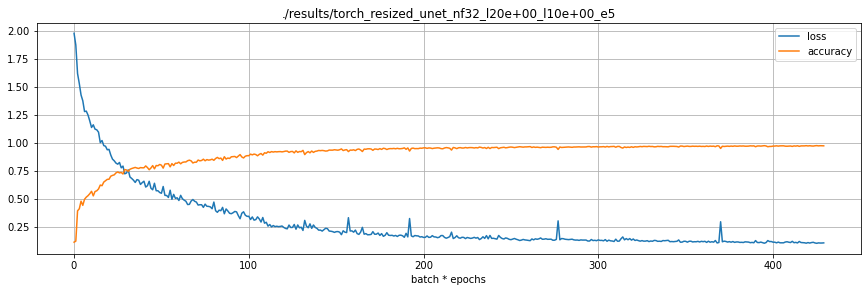

In [183]:
plt.figure(figsize=(12,4))
plt.plot(loss, label='loss')
plt.plot(acc, label='accuracy')
plt.xlabel('batch * epochs')
plt.grid(True)
plt.title(outpath)
plt.tight_layout(pad=0.5)
plt.legend()
plt.savefig(os.path.join(outpath, 'loss.png'))
plt.show()

In [184]:
model = torch.load(os.path.join(outpath, '_model.pth'))#, map_location='cpu')

In [185]:
gy_label, gy_onehot = seisfacies_predict(model, training_img_data[420],onehot=1, device=device)

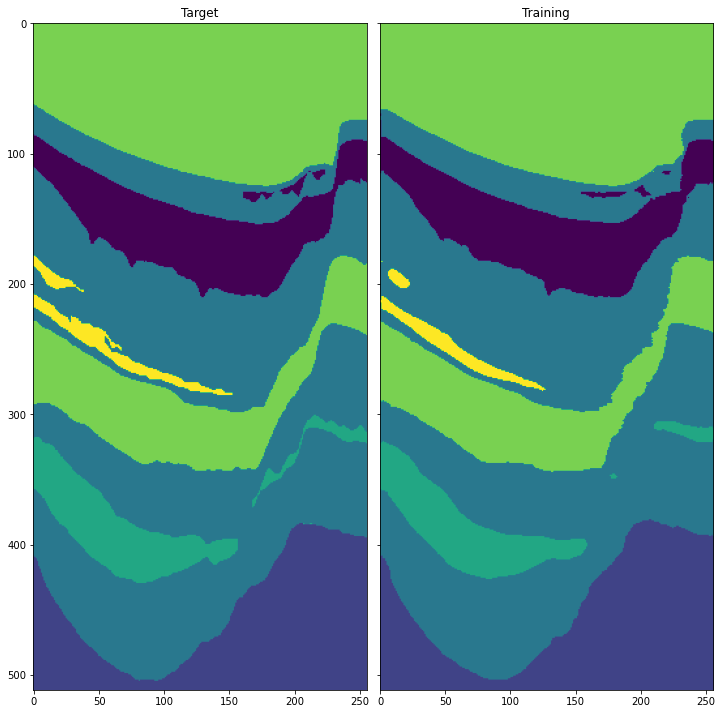

In [186]:
f, axarr = plt.subplots(1,2, sharey=True, figsize=(10,10))
axarr[1].imshow(gy_label)
axarr[1].set_title('Output')
axarr[0].imshow(training_label_data[420])
axarr[0].set_title('Target')
plt.title('Training')
plt.tight_layout(pad=0.5)
plt.savefig(os.path.join(outpath, 'training.png'))
plt.show()

## Test

In [168]:
test_seismic = np.load(os.path.join(rootpath, 'data_test_1.npz'), mmap_mode='r')['data']

In [169]:
test_seismic.shape

(1006, 782, 251)

In [ ]:
test_seismict_seismic = normalize_only(test_seismic, in_min=_min, in_max=_max)

In [170]:
testing_img_data = []

for i in trange(0, test_seismic.shape[1], desc='ZY sections'):
    img = test_seismic[:,i,:]
    img = np.expand_dims(img, axis=2).astype('float32')
    img = cv2.resize(img, (256, 512))
    testing_img_data.append(img) 

for i in trange(0, test_seismic.shape[2], desc='ZX sections'):
    img = test_seismic[:,:,i]
    img = np.expand_dims(img, axis=2).astype('float32')
    img = cv2.resize(img, (256, 512))
    testing_img_data.append(img) 

testing_img_data = np.asarray(testing_img_data)

In [171]:
testing_img_data.shape

(1033, 512, 256)

In [187]:
%%time
pred_sections = []

for i in trange(0, test_seismic.shape[1], desc='ZY sections'):
    
    gy_label, gy_onehot = seisfacies_predict(model, testing_img_data[i],onehot=1, device=device)
    pred_sections.append(gy_label)


CPU times: user 39.9 s, sys: 3.9 s, total: 43.8 s
Wall time: 43.7 s


In [188]:
predictions = np.asarray(pred_sections)

In [189]:
test_seismic.shape, predictions.shape

((1006, 782, 251), (782, 512, 256))

In [190]:
def reshaping(data, out_shape):
    
    output_labels = []
    
    for i in data:
        img = np.expand_dims(i, axis=2).astype('float32')
        img = cv2.resize(img, out_shape)
        output_labels.append(img)
        
    output_labels = np.asarray(output_labels).astype(int) 
    
    return np.swapaxes(output_labels, 0, 1) 

In [191]:
preds = reshaping(predictions, (251,1006))

### Restore original labeling

In [31]:
preds_new = preds.copy()

# dove era 0 abbiamo messo 2, quindi dove c'è 2 dobbiamo rimettere 0
for i,c in enumerate(new_class_ids):
    #print(i, c)
    preds[preds_new==c] = i

del preds_new

0 2
1 0
2 3
3 4
4 5
5 1


In [192]:
preds[preds == 0] = 6

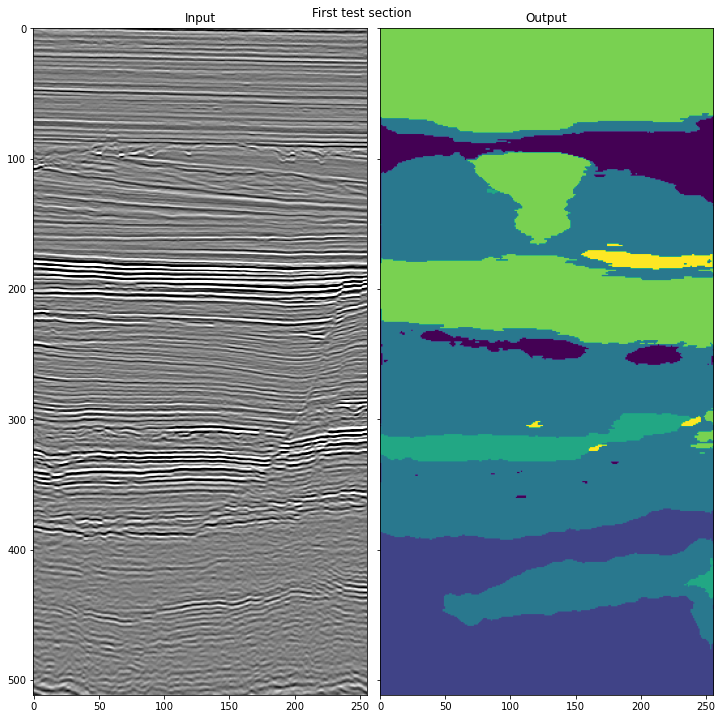

In [193]:
section_idx = 0

section = testing_img_data[section_idx]
output = pred_sections[section_idx]

clipval = np.percentile(np.absolute(section), 95)

f, axarr = plt.subplots(1,2, sharey=True, figsize=(10,10))
axarr[1].imshow(output)
axarr[1].set_title('Output')
axarr[0].imshow(section, cmap='gray', vmin=-clipval, vmax=clipval)
axarr[0].set_title('Input')

f.suptitle('First test section')
plt.tight_layout(pad=0.5)
plt.savefig(os.path.join(outpath, 'test.png'))
plt.show()

In [29]:
np.savez_compressed("./facies_aicrowd_submissions/submission013.npz",
                    prediction=preds.astype(np.uint8)
)